# Neural Networks with Keras
March 13, 2019.

Luis Da Silva.
### MNIST Digit Recognition

Extend MLP excersize from training dataset. Select a list of hyperparameters to evaluate and create a grid with them. Make plots where necessary.

Hyperparameters to consider:
- Number of layers
- Activation functions
- Number of Epochs
- Dropouts

See: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from joblib import dump, load
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD, Adam, RMSprop
from keras.datasets import mnist
from keras.utils import np_utils

np.random.seed(4526)

Using TensorFlow backend.


# Load and transform data

In [2]:
def read_transform_mnist():
    mn = {}
    # Read dataset
    (input_X_train, output_Y_train), (input_X_test, output_Y_test) = mnist.load_data()
    mn['nclasses'] = len(np.unique(output_Y_test))
    mn['dimmension'] = input_X_train.shape[1] * input_X_train.shape[2]
    
    # Flatten
    mn['input_X_train'] = input_X_train.reshape(input_X_train.shape[0], mn['dimmension']).astype('float32')
    mn['input_X_test'] = input_X_test.reshape(input_X_test.shape[0], mn['dimmension']).astype('float32')

    # Now rescale to values between 0 and 1
    mn['input_X_train'] /= mn['input_X_train'].max()
    mn['input_X_test'] /= mn['input_X_test'].max()

    # Convert to categorical
    mn['output_Y_train'] = np_utils.to_categorical(output_Y_train, mn['nclasses'])
    mn['output_Y_test'] = np_utils.to_categorical(output_Y_test, mn['nclasses'])
    
    return mn

In [3]:
mn = read_transform_mnist()

# Defining functions to make training models easier

In [4]:
def train_evaluate(model, mn, epochs = 20, batch_size=128, validation_split=0.2, 
                   verbose='one', repeat=10, plot=True, img_name=None, model_name='auto'):
    results = pd.DataFrame()
    test_score = []
    test_acc = []
    ini = dt.datetime.now()
    
    if verbose == 'results':
        v = 0
    else:
        v = 1
        
    for i in range(repeat):
        model.reset_states() # Start with a random model
        rini = dt.datetime.now()
        if verbose == 'one' and i!=0:
            v = 0
        
        # Train model
        history = model.fit(mn['input_X_train'], mn['output_Y_train'], batch_size=128, epochs=epochs, 
                            verbose=v, validation_split=validation_split)
        results['acc_{}'.format(i)] = history.history['acc']
        results['val_acc_{}'.format(i)] = history.history['val_acc']
        
        # Score on validation set
        score = model.evaluate(mn['input_X_test'], mn['output_Y_test'], verbose=v)
        test_score.append(score[0])
        test_acc.append(score[1])
        
        #Print round results
        now = dt.datetime.now()
        print('*--'*30)
        print('Round: {}. Time: {}. Total time: {}. Expected: {}'.format(i+1, now-rini, now-ini, (now-ini)*repeat/(1+i)))
        print("Test score:", score[0])
        print("Test accuracy:", score[1])
        
    # Plot
    if plot:
        if model_name == 'auto':
            model_name = model.__name__
        
        acc = ['acc_{}'.format(i) for i in range(repeat)]
        val_acc = ['val_acc_{}'.format(i) for i in range(repeat)]
        acc_mean = results[acc].mean(axis=1)
        val_acc_mean = results[val_acc].mean(axis=1)
        
        plt.plot(acc_mean, label='Train')
        plt.plot(val_acc_mean, label='Test')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        if model_name is not None:
            plt.title('Model {} accuracy'.format(model_name))
        if img_name is not None:
            plt.savefig('Graphs/{}.png'.format(img_name))
        
        plt.show()
        
    print('*--'*30)
    print('Mean test acc:', np.mean(test_acc)) 
    return {'history_acc':acc_mean, 'history_val_acc':val_acc_mean,'test_scores':test_score, 'test_acc':test_acc}

In [5]:
class Model:
    def __init__(self, classes, dimmension, data):
        self.classes = classes
        self.dimmension = dimmension
        self.hlayers = 0
        self.epochs = 20
        self.hidden_units = 128
        self.activation = 'relu'
        self.dropout = None
        self.optimizer = SGD
        self.optimizer_name = type(self.optimizer).__name__
        self.optimizer_params = {}
        self.batch_size = 128
        self.acc = 0
        self.data = data
        self.previous_history = None

    def create_model(self, hlayers, hidden_units, activation, dropout, optimizer):
        self.model = Sequential()

        # Add layers
        for i in range(hlayers):
            self.model.add(Dense(hidden_units, input_shape=(self.dimmension,)))
            self.model.add(Activation(activation))
            if dropout is not None:
                self.model.add(Dropout(dropout))

        # Add output layer
        self.model.add(Dense(self.classes))
        self.model.add(Activation('softmax'))

        # Compile
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer,
                           metrics=['accuracy'])

    def best_model_summary(self):
        print('Hidden Layers: {}'.format(self.hlayers))
        print('Hidden Units: {}'.format(self.hidden_units))
        print('Epochs: {}'.format(self.epochs))
        print('Activation: {}'.format(self.activation))
        print('Dropout: {}'.format(self.dropout))
        print('Optimizer: {}'.format(self.optimizer_name))
        print('Batch size: {}'.format(self.batch_size))
        print('Accuracy: {}'.format(self.acc))
        self.model.summary()

    def create_train(self, repeat=5, epochs=None, hlayers=None, hidden_units=None,
                    activation=None, dropout=None, optimizer=None, batch_size=None,
                    optimizer_params={}):
        hlayers = self.hlayers if hlayers is None else hlayers
        hidden_units = self.hidden_units if hidden_units is None else hidden_units
        activation = self.activation if activation is None else activation
        dropout = self.dropout if dropout is None else dropout
        optimizer_name = self.optimizer_name if optimizer is None else type(optimizer).__name__
        optimizer = self.optimizer if optimizer is None else optimizer
        optimizer_params = self.optimizer_params if optimizer_params is None else optimizer_params

        call_optimizer = optimizer(**optimizer_params)
        
        self.create_model(hlayers, hidden_units, activation, dropout, call_optimizer)
        
        epochs = self.epochs if epochs is None else epochs
        batch_size = self.batch_size if batch_size is None else batch_size
        
        name = '{}HL_{}HU_{} activation_{} dropout_{} optimizer_{} epochs_{} batch'. \
            format(hlayers, hidden_units, activation, dropout, optimizer_name, epochs, batch_size)
        results = train_evaluate(self.model, self.data, epochs = epochs, batch_size=batch_size,
                                 validation_split=0.2, verbose='one', repeat=repeat, img_name=name, 
                                          model_name=None)
        
        test_result = np.mean(results['test_acc'])
        if test_result > self.acc:
            self.hlayers = hlayers
            self.epochs = epochs
            self.hidden_units = hidden_units
            self.activation = activation
            self.dropout = dropout
            self.optimizer = optimizer
            self.batch_size = batch_size
            self.acc = test_result
            self.optimizer_name = type(optimizer).__name__
            self.best_history = results['history_val_acc']
            print("Better model found!")

        self.model.summary()
        return results
    
    def update_history(self):
        self.previous_history = self.best_history
    
    def plot_comparison(self, results, keys, names, suffix, abbr):
        plt.plot(self.previous_history, label='Previous best model')
        for key, name in zip(keys, names):
            label = '{} {}'.format(name, suffix)
            plt.plot(results[key]['history_val_acc'], label=label)
        plt.xlabel('Epochs')
        plt.ylabel('Test Accuracy')
        plt.legend()
        plt.savefig('Graphs/comparison_{}.png'.format(abbr))
        plt.show()
        
        self.update_history()

In [6]:
def dump_all(model, results):
    dump(model, 'results/model.joblib')
    dump(results, 'results/results.joblib')

In [7]:
def evaluate_hp(model, results, param, variations, param_name, param_abbr):
    keys = ['MLP_{}{}'.format(i, param_abbr) for i in variations]
    for variation, key in zip(variations, keys):
        results[key] = model.create_train(**{param:variation})

    model.best_model_summary()
    model.plot_comparison(results, keys, variations, param_name, param_abbr)
    dump_all(model, results)
    
    return results

In [8]:
model = Model(mn['nclasses'], mn['dimmension'], mn)

# Exploring the effect of each parameter

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 3s 71us/step - loss: 1.4011 - acc: 0.6646 - val_loss: 0.8993 - val_acc: 0.8260
Epoch 2/20
48000/48000 [==============================] - 1s 24us/step - loss: 0.7961 - acc: 0.8266 - val_loss: 0.6612 - val_acc: 0.8571
Epoch 3/20
48000/48000 [==============================] - 1s 23us/step - loss: 0.6459 - acc: 0.8484 - val_loss: 0.5654 - val_acc: 0.8685
Epoch 4/20
48000/48000 [==============================] - 1s 24us/step - loss: 0.5734 - acc: 0.8597 - val_loss: 0.5124 - val_acc: 0.8754
Epoch 5/20
48000/48000 [==============================] - 1s 23us/step - loss: 0.5292 - acc: 0.8671 - val_loss: 0.4783 - val_acc: 0.8804
Epoch 6/20
48000/48000 [==============================] - 1s 23us/step - loss: 0.4988 - acc: 0.8721 - val_loss: 0.4540 - val_acc: 0.8847
Epoch 7/20
48000/48000 [==============================] - 1s 23us/step - loss: 0.4763 - acc: 0.8760 - val_loss: 0.4357 - val_acc

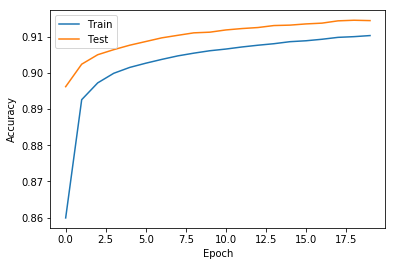

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.91482
Better model found!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Simple Perceptron
results = {}
results['SP'] = model.create_train()
model.update_history()
dump_all(model, results)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 1s 31us/step - loss: 1.2767 - acc: 0.6896 - val_loss: 0.7132 - val_acc: 0.8490
Epoch 2/20
48000/48000 [==============================] - 1s 27us/step - loss: 0.6129 - acc: 0.8545 - val_loss: 0.4895 - val_acc: 0.8801
Epoch 3/20
48000/48000 [==============================] - 1s 26us/step - loss: 0.4791 - acc: 0.8774 - val_loss: 0.4136 - val_acc: 0.8902
Epoch 4/20
48000/48000 [==============================] - 1s 27us/step - loss: 0.4213 - acc: 0.8873 - val_loss: 0.3751 - val_acc: 0.8984
Epoch 5/20
48000/48000 [==============================] - 1s 26us/step - loss: 0.3875 - acc: 0.8941 - val_loss: 0.3496 - val_acc: 0.9042
Epoch 6/20
48000/48000 [==============================] - 1s 26us/step - loss: 0.3644 - acc: 0.8992 - val_loss: 0.3326 - val_acc: 0.9083
Epoch 7/20
48000/48000 [==============================] - 1s 26us/step - loss: 0.3471 - acc: 0.9034 - val_loss: 0.3184 - val_acc

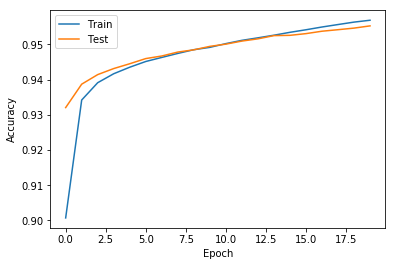

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.95328
Better model found!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 2s 34us/step - loss: 1.552

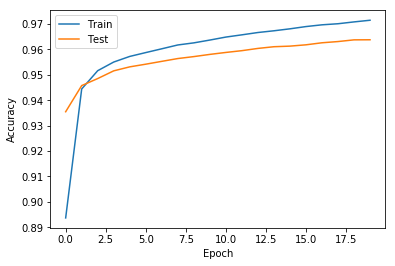

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.96226
Better model found!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
Total pa

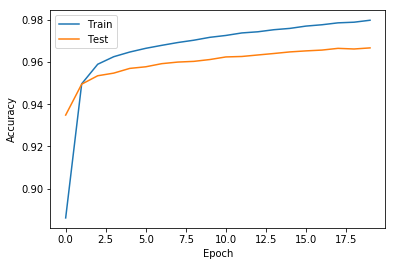

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.96746
Better model found!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_9 (Activation)    (None, 128)               0         
________

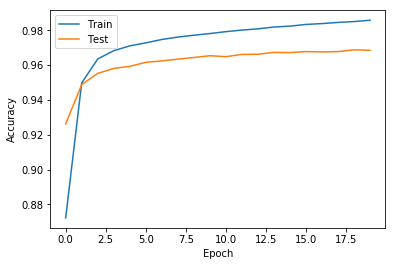

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.9698599999999999
Better model found!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               100480    
_________________________________________________________________
activation_11 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_12 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_13 (Activation)   (None, 128)               0       

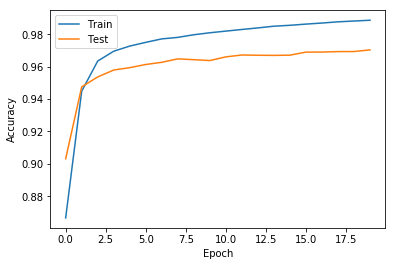

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.97036
Better model found!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               100480    
_________________________________________________________________
activation_16 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_17 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_18 (Activation)   (None, 128)               0         
________

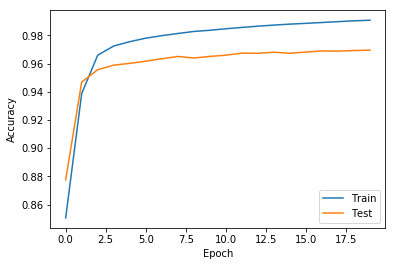

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.9681200000000001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               100480    
_________________________________________________________________
activation_22 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_23 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_24 (Activation)   (None, 128)               0         
_________________

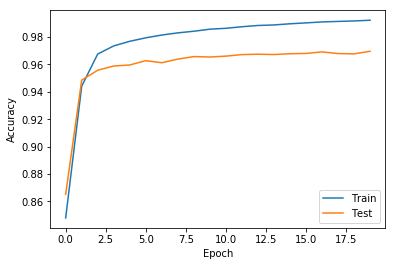

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.9663
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 128)               100480    
_________________________________________________________________
activation_29 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_30 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_31 (Activation)   (None, 128)               0         
_____________________________

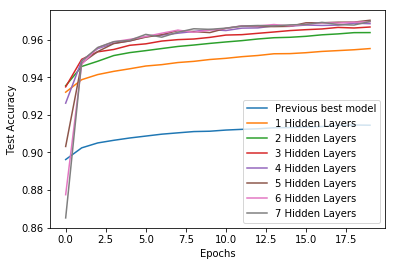

In [10]:
# Adding Hidden Layers
results = evaluate_hp(model, results, 'hlayers', range(1,8), 'Hidden Layers', 'HL')

Train on 48000 samples, validate on 12000 samples
Epoch 1/150
48000/48000 [==============================] - 2s 45us/step - loss: 1.9386 - acc: 0.4591 - val_loss: 1.0766 - val_acc: 0.6976
Epoch 2/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.7030 - acc: 0.7956 - val_loss: 0.4620 - val_acc: 0.8697
Epoch 3/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.4249 - acc: 0.8773 - val_loss: 0.3479 - val_acc: 0.8997
Epoch 4/150
48000/48000 [==============================] - 2s 37us/step - loss: 0.3412 - acc: 0.9003 - val_loss: 0.2930 - val_acc: 0.9136
Epoch 5/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.2955 - acc: 0.9137 - val_loss: 0.2598 - val_acc: 0.9241
Epoch 6/150
48000/48000 [==============================] - 2s 35us/step - loss: 0.2641 - acc: 0.9221 - val_loss: 0.2385 - val_acc: 0.9313
Epoch 7/150
48000/48000 [==============================] - 2s 35us/step - loss: 0.2379 - acc: 0.9304 - val_loss: 0.2167 - 

Epoch 118/150
48000/48000 [==============================] - 2s 37us/step - loss: 0.0026 - acc: 0.9999 - val_loss: 0.1457 - val_acc: 0.9710
Epoch 119/150
48000/48000 [==============================] - 2s 37us/step - loss: 0.0026 - acc: 0.9999 - val_loss: 0.1466 - val_acc: 0.9709
Epoch 120/150
48000/48000 [==============================] - 2s 35us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.1470 - val_acc: 0.9712
Epoch 121/150
48000/48000 [==============================] - 2s 35us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.1469 - val_acc: 0.9712
Epoch 122/150
48000/48000 [==============================] - 2s 34us/step - loss: 0.0025 - acc: 0.9999 - val_loss: 0.1480 - val_acc: 0.9706
Epoch 123/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.0024 - acc: 0.9999 - val_loss: 0.1479 - val_acc: 0.9707
Epoch 124/150
48000/48000 [==============================] - 2s 34us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.1482 - val_acc: 0.9703
Epoch 125/150
48000/

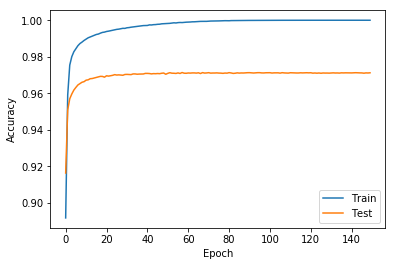

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.97244
Better model found!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 128)               100480    
_________________________________________________________________
activation_37 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_38 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_39 (Activation)   (None, 128)               0         
________

Epoch 45/250
48000/48000 [==============================] - 2s 37us/step - loss: 0.0441 - acc: 0.9878 - val_loss: 0.1100 - val_acc: 0.9683
Epoch 46/250
48000/48000 [==============================] - 2s 39us/step - loss: 0.0424 - acc: 0.9882 - val_loss: 0.1083 - val_acc: 0.9707
Epoch 47/250
48000/48000 [==============================] - 2s 36us/step - loss: 0.0411 - acc: 0.9887 - val_loss: 0.1105 - val_acc: 0.9683
Epoch 48/250
48000/48000 [==============================] - 2s 35us/step - loss: 0.0395 - acc: 0.9892 - val_loss: 0.1096 - val_acc: 0.9698
Epoch 49/250
48000/48000 [==============================] - 2s 35us/step - loss: 0.0376 - acc: 0.9903 - val_loss: 0.1113 - val_acc: 0.9697
Epoch 50/250
48000/48000 [==============================] - 2s 34us/step - loss: 0.0362 - acc: 0.9905 - val_loss: 0.1163 - val_acc: 0.9690
Epoch 51/250
48000/48000 [==============================] - 2s 34us/step - loss: 0.0346 - acc: 0.9914 - val_loss: 0.1079 - val_acc: 0.9711
Epoch 52/250
48000/48000 [=

Epoch 104/250
48000/48000 [==============================] - 2s 34us/step - loss: 0.0037 - acc: 0.9997 - val_loss: 0.1394 - val_acc: 0.9708
Epoch 105/250
48000/48000 [==============================] - 2s 35us/step - loss: 0.0036 - acc: 0.9997 - val_loss: 0.1409 - val_acc: 0.9698
Epoch 106/250
48000/48000 [==============================] - 2s 35us/step - loss: 0.0034 - acc: 0.9998 - val_loss: 0.1404 - val_acc: 0.9705
Epoch 107/250
48000/48000 [==============================] - 2s 35us/step - loss: 0.0033 - acc: 0.9998 - val_loss: 0.1415 - val_acc: 0.9709
Epoch 108/250
48000/48000 [==============================] - 2s 35us/step - loss: 0.0032 - acc: 0.9998 - val_loss: 0.1419 - val_acc: 0.9706
Epoch 109/250
48000/48000 [==============================] - 2s 34us/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.1432 - val_acc: 0.9702
Epoch 110/250
48000/48000 [==============================] - 2s 35us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1429 - val_acc: 0.9702
Epoch 111/250
48000/

Epoch 219/250
48000/48000 [==============================] - 2s 34us/step - loss: 4.3314e-04 - acc: 1.0000 - val_loss: 0.1721 - val_acc: 0.9706
Epoch 220/250
48000/48000 [==============================] - 2s 35us/step - loss: 4.2811e-04 - acc: 1.0000 - val_loss: 0.1722 - val_acc: 0.9705
Epoch 221/250
48000/48000 [==============================] - 2s 35us/step - loss: 4.2486e-04 - acc: 1.0000 - val_loss: 0.1725 - val_acc: 0.9708
Epoch 222/250
48000/48000 [==============================] - 2s 34us/step - loss: 4.1975e-04 - acc: 1.0000 - val_loss: 0.1724 - val_acc: 0.9706
Epoch 223/250
48000/48000 [==============================] - 2s 34us/step - loss: 4.1694e-04 - acc: 1.0000 - val_loss: 0.1727 - val_acc: 0.9711
Epoch 224/250
48000/48000 [==============================] - 2s 35us/step - loss: 4.1297e-04 - acc: 1.0000 - val_loss: 0.1730 - val_acc: 0.9703
Epoch 225/250
48000/48000 [==============================] - 2s 34us/step - loss: 4.0857e-04 - acc: 1.0000 - val_loss: 0.1728 - val_acc:

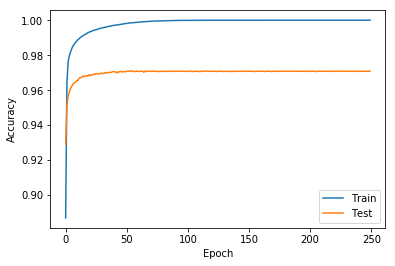

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.97058
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 128)               100480    
_________________________________________________________________
activation_43 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_44 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_45 (Activation)   (None, 128)               0         
____________________________

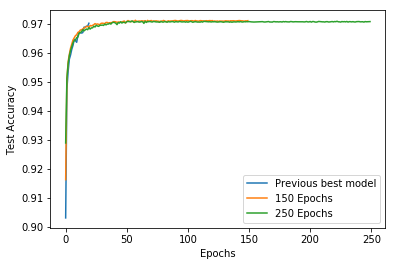

In [11]:
# Change the number of epochs
results = evaluate_hp(model, results, 'epochs', (150,250), 'Epochs', 'E')

Train on 48000 samples, validate on 12000 samples
Epoch 1/150
48000/48000 [==============================] - 2s 47us/step - loss: 2.0644 - acc: 0.3414 - val_loss: 1.3730 - val_acc: 0.6243
Epoch 2/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.8484 - acc: 0.7449 - val_loss: 0.5814 - val_acc: 0.8211
Epoch 3/150
48000/48000 [==============================] - 2s 35us/step - loss: 0.5294 - acc: 0.8438 - val_loss: 0.4275 - val_acc: 0.8723
Epoch 4/150
48000/48000 [==============================] - 2s 35us/step - loss: 0.4161 - acc: 0.8784 - val_loss: 0.3599 - val_acc: 0.8915
Epoch 5/150
48000/48000 [==============================] - 2s 35us/step - loss: 0.3561 - acc: 0.8969 - val_loss: 0.3191 - val_acc: 0.9067
Epoch 6/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.3150 - acc: 0.9083 - val_loss: 0.2905 - val_acc: 0.9172
Epoch 7/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.2864 - acc: 0.9169 - val_loss: 0.2637 - 

Epoch 118/150
48000/48000 [==============================] - 2s 35us/step - loss: 0.0064 - acc: 0.9992 - val_loss: 0.1604 - val_acc: 0.9669
Epoch 119/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.0061 - acc: 0.9993 - val_loss: 0.1610 - val_acc: 0.9672
Epoch 120/150
48000/48000 [==============================] - 2s 35us/step - loss: 0.0060 - acc: 0.9992 - val_loss: 0.1663 - val_acc: 0.9662
Epoch 121/150
48000/48000 [==============================] - 2s 35us/step - loss: 0.0057 - acc: 0.9993 - val_loss: 0.1616 - val_acc: 0.9667
Epoch 122/150
48000/48000 [==============================] - 2s 34us/step - loss: 0.0056 - acc: 0.9994 - val_loss: 0.1642 - val_acc: 0.9673
Epoch 123/150
48000/48000 [==============================] - 2s 34us/step - loss: 0.0053 - acc: 0.9994 - val_loss: 0.1640 - val_acc: 0.9674
Epoch 124/150
48000/48000 [==============================] - 2s 34us/step - loss: 0.0051 - acc: 0.9996 - val_loss: 0.1663 - val_acc: 0.9669
Epoch 125/150
48000/

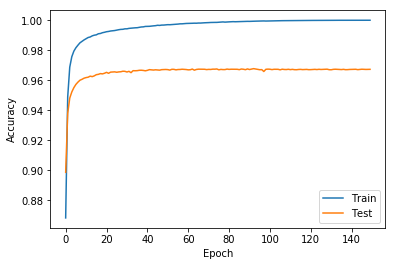

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.9708600000000001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 64)                50240     
_________________________________________________________________
activation_49 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_50 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_51 (Activation)   (None, 64)                0         
_________________

Epoch 45/150
48000/48000 [==============================] - 2s 37us/step - loss: 0.0284 - acc: 0.9933 - val_loss: 0.1003 - val_acc: 0.9725
Epoch 46/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.0270 - acc: 0.9940 - val_loss: 0.0976 - val_acc: 0.9728
Epoch 47/150
48000/48000 [==============================] - 2s 37us/step - loss: 0.0257 - acc: 0.9945 - val_loss: 0.1010 - val_acc: 0.9725
Epoch 48/150
48000/48000 [==============================] - 2s 37us/step - loss: 0.0248 - acc: 0.9944 - val_loss: 0.1027 - val_acc: 0.9700
Epoch 49/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.0231 - acc: 0.9949 - val_loss: 0.0997 - val_acc: 0.9717
Epoch 50/150
48000/48000 [==============================] - 2s 37us/step - loss: 0.0224 - acc: 0.9951 - val_loss: 0.1044 - val_acc: 0.9710
Epoch 51/150
48000/48000 [==============================] - 2s 39us/step - loss: 0.0211 - acc: 0.9955 - val_loss: 0.0980 - val_acc: 0.9728
Epoch 52/150
48000/48000 [=

Epoch 104/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.1200 - val_acc: 0.9750
Epoch 105/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.1206 - val_acc: 0.9748
Epoch 106/150
48000/48000 [==============================] - 2s 37us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.1209 - val_acc: 0.9740
Epoch 107/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.1211 - val_acc: 0.9746
Epoch 108/150
48000/48000 [==============================] - 2s 37us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.1212 - val_acc: 0.9750
Epoch 109/150
48000/48000 [==============================] - 2s 36us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.1225 - val_acc: 0.9749
Epoch 110/150
48000/48000 [==============================] - 2s 37us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.1226 - val_acc: 0.9749
Epoch 111/150
48000/

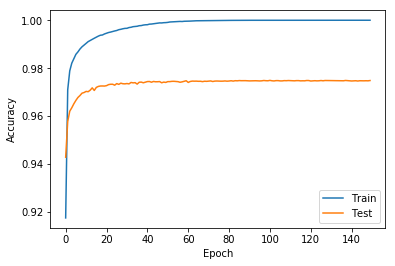

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.97698
Better model found!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_55 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_56 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_57 (Activation)   (None, 256)               0         
________

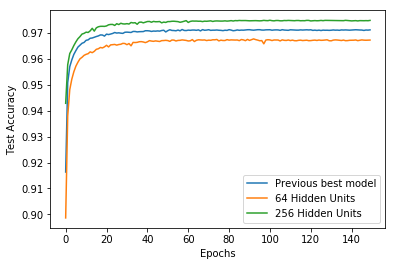

In [12]:
# Change the number of Hidden Units
results = evaluate_hp(model, results, 'hidden_units', (64,256), 'Hidden Units', 'HU')

Train on 48000 samples, validate on 12000 samples
Epoch 1/150
48000/48000 [==============================] - 3s 59us/step - loss: 0.8539 - acc: 0.7798 - val_loss: 0.4441 - val_acc: 0.8810
Epoch 2/150
48000/48000 [==============================] - 2s 45us/step - loss: 0.4113 - acc: 0.8841 - val_loss: 0.3439 - val_acc: 0.9021
Epoch 3/150
48000/48000 [==============================] - 2s 46us/step - loss: 0.3448 - acc: 0.9015 - val_loss: 0.3063 - val_acc: 0.9117
Epoch 4/150
48000/48000 [==============================] - 2s 45us/step - loss: 0.3117 - acc: 0.9097 - val_loss: 0.2850 - val_acc: 0.9171
Epoch 5/150
48000/48000 [==============================] - 2s 46us/step - loss: 0.2896 - acc: 0.9163 - val_loss: 0.2678 - val_acc: 0.9230
Epoch 6/150
48000/48000 [==============================] - 2s 45us/step - loss: 0.2724 - acc: 0.9214 - val_loss: 0.2553 - val_acc: 0.9268
Epoch 7/150
48000/48000 [==============================] - 2s 50us/step - loss: 0.2579 - acc: 0.9248 - val_loss: 0.2427 - 

Epoch 118/150
48000/48000 [==============================] - 2s 40us/step - loss: 0.0075 - acc: 0.9993 - val_loss: 0.0946 - val_acc: 0.9747
Epoch 119/150
48000/48000 [==============================] - 2s 40us/step - loss: 0.0072 - acc: 0.9994 - val_loss: 0.0960 - val_acc: 0.9741
Epoch 120/150
48000/48000 [==============================] - 2s 39us/step - loss: 0.0070 - acc: 0.9994 - val_loss: 0.0956 - val_acc: 0.9751
Epoch 121/150
48000/48000 [==============================] - 2s 39us/step - loss: 0.0068 - acc: 0.9995 - val_loss: 0.0961 - val_acc: 0.9747
Epoch 122/150
48000/48000 [==============================] - 2s 41us/step - loss: 0.0066 - acc: 0.9995 - val_loss: 0.0959 - val_acc: 0.9749
Epoch 123/150
48000/48000 [==============================] - 2s 40us/step - loss: 0.0065 - acc: 0.9995 - val_loss: 0.0969 - val_acc: 0.9750
Epoch 124/150
48000/48000 [==============================] - 3s 55us/step - loss: 0.0063 - acc: 0.9995 - val_loss: 0.0971 - val_acc: 0.9754
Epoch 125/150
48000/

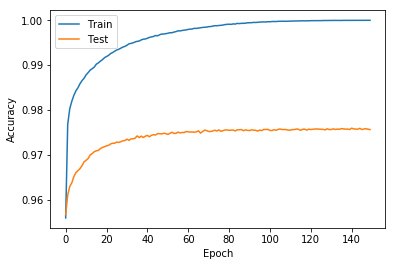

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.97776
Better model found!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_61 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_62 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_63 (Activation)   (None, 256)               0         
________

Epoch 45/150
48000/48000 [==============================] - 2s 38us/step - loss: 2.3017 - acc: 0.1120 - val_loss: 2.3025 - val_acc: 0.1060
Epoch 46/150
48000/48000 [==============================] - 2s 38us/step - loss: 2.3018 - acc: 0.1108 - val_loss: 2.3024 - val_acc: 0.1060
Epoch 47/150
48000/48000 [==============================] - 2s 38us/step - loss: 2.3018 - acc: 0.1112 - val_loss: 2.3039 - val_acc: 0.1060
Epoch 48/150
48000/48000 [==============================] - 2s 39us/step - loss: 2.3018 - acc: 0.1113 - val_loss: 2.3014 - val_acc: 0.1035
Epoch 49/150
48000/48000 [==============================] - 2s 38us/step - loss: 2.3017 - acc: 0.1118 - val_loss: 2.3023 - val_acc: 0.1060
Epoch 50/150
48000/48000 [==============================] - 2s 39us/step - loss: 2.3016 - acc: 0.1125 - val_loss: 2.3026 - val_acc: 0.1060
Epoch 51/150
48000/48000 [==============================] - 2s 39us/step - loss: 2.3017 - acc: 0.1126 - val_loss: 2.3012 - val_acc: 0.1060
Epoch 52/150
48000/48000 [=

Epoch 104/150
48000/48000 [==============================] - 2s 38us/step - loss: 2.3001 - acc: 0.1165 - val_loss: 2.3010 - val_acc: 0.1060
Epoch 105/150
48000/48000 [==============================] - 2s 39us/step - loss: 2.3001 - acc: 0.1143 - val_loss: 2.2999 - val_acc: 0.1081
Epoch 106/150
48000/48000 [==============================] - 2s 38us/step - loss: 2.3000 - acc: 0.1167 - val_loss: 2.3005 - val_acc: 0.1060
Epoch 107/150
48000/48000 [==============================] - 2s 39us/step - loss: 2.3002 - acc: 0.1153 - val_loss: 2.3011 - val_acc: 0.1060
Epoch 108/150
48000/48000 [==============================] - 2s 38us/step - loss: 2.2999 - acc: 0.1181 - val_loss: 2.3001 - val_acc: 0.1060
Epoch 109/150
48000/48000 [==============================] - 2s 38us/step - loss: 2.2998 - acc: 0.1160 - val_loss: 2.3004 - val_acc: 0.0997
Epoch 110/150
48000/48000 [==============================] - 2s 38us/step - loss: 2.2996 - acc: 0.1161 - val_loss: 2.3021 - val_acc: 0.1060
Epoch 111/150
48000/

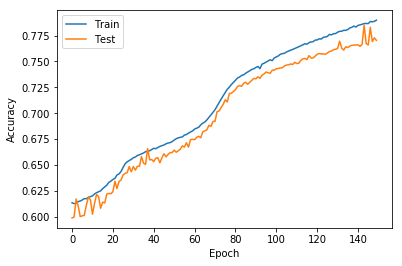

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.77032
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_67 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_68 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_69 (Activation)   (None, 256)               0         
____________________________

48000/48000 [==============================] - 2s 38us/step - loss: 0.0597 - acc: 0.9829 - val_loss: 0.1037 - val_acc: 0.9698
Epoch 46/150
48000/48000 [==============================] - 2s 38us/step - loss: 0.0585 - acc: 0.9830 - val_loss: 0.0996 - val_acc: 0.9703
Epoch 47/150
48000/48000 [==============================] - 2s 39us/step - loss: 0.0567 - acc: 0.9839 - val_loss: 0.1011 - val_acc: 0.9703
Epoch 48/150
48000/48000 [==============================] - 2s 38us/step - loss: 0.0552 - acc: 0.9844 - val_loss: 0.1001 - val_acc: 0.9702
Epoch 49/150
48000/48000 [==============================] - 2s 38us/step - loss: 0.0533 - acc: 0.9846 - val_loss: 0.1005 - val_acc: 0.9708
Epoch 50/150
48000/48000 [==============================] - 2s 38us/step - loss: 0.0525 - acc: 0.9848 - val_loss: 0.1019 - val_acc: 0.9700
Epoch 51/150
48000/48000 [==============================] - 2s 38us/step - loss: 0.0508 - acc: 0.9853 - val_loss: 0.0986 - val_acc: 0.9701
Epoch 52/150
48000/48000 [==============

48000/48000 [==============================] - 2s 39us/step - loss: 0.0110 - acc: 0.9981 - val_loss: 0.1021 - val_acc: 0.9739
Epoch 105/150
48000/48000 [==============================] - 2s 39us/step - loss: 0.0109 - acc: 0.9981 - val_loss: 0.1016 - val_acc: 0.9743
Epoch 106/150
48000/48000 [==============================] - 2s 42us/step - loss: 0.0105 - acc: 0.9982 - val_loss: 0.1021 - val_acc: 0.9736
Epoch 107/150
48000/48000 [==============================] - 2s 39us/step - loss: 0.0101 - acc: 0.9987 - val_loss: 0.1023 - val_acc: 0.9736
Epoch 108/150
48000/48000 [==============================] - 2s 39us/step - loss: 0.0099 - acc: 0.9987 - val_loss: 0.1021 - val_acc: 0.9739
Epoch 109/150
48000/48000 [==============================] - 2s 39us/step - loss: 0.0097 - acc: 0.9988 - val_loss: 0.1036 - val_acc: 0.9740
Epoch 110/150
48000/48000 [==============================] - 2s 39us/step - loss: 0.0092 - acc: 0.9987 - val_loss: 0.1044 - val_acc: 0.9736
Epoch 111/150
48000/48000 [=======

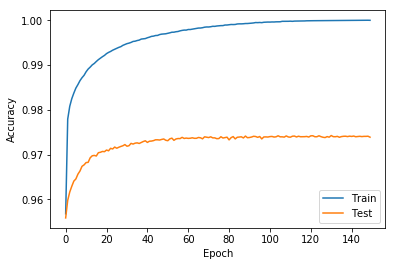

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.9759800000000001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_73 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_74 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_75 (Activation)   (None, 256)               0         
_________________

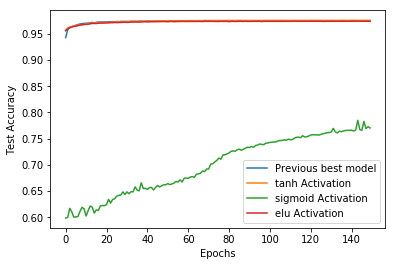

In [13]:
# Change the activation functions
results = evaluate_hp(model, results, 'activation', ('tanh', 'sigmoid', 'elu'), 'Activation', 'Act')

Train on 48000 samples, validate on 12000 samples
Epoch 1/150
48000/48000 [==============================] - 3s 62us/step - loss: 0.9686 - acc: 0.7256 - val_loss: 0.4378 - val_acc: 0.8805
Epoch 2/150
48000/48000 [==============================] - 2s 44us/step - loss: 0.4779 - acc: 0.8597 - val_loss: 0.3440 - val_acc: 0.9001
Epoch 3/150
48000/48000 [==============================] - 2s 43us/step - loss: 0.4096 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.9095
Epoch 4/150
48000/48000 [==============================] - 2s 44us/step - loss: 0.3751 - acc: 0.8893 - val_loss: 0.2909 - val_acc: 0.9171
Epoch 5/150
48000/48000 [==============================] - 2s 43us/step - loss: 0.3520 - acc: 0.8949 - val_loss: 0.2800 - val_acc: 0.9181
Epoch 6/150
48000/48000 [==============================] - 2s 44us/step - loss: 0.3368 - acc: 0.9003 - val_loss: 0.2726 - val_acc: 0.9212
Epoch 7/150
48000/48000 [==============================] - 2s 44us/step - loss: 0.3264 - acc: 0.9021 - val_loss: 0.2623 - 

Epoch 118/150
48000/48000 [==============================] - 2s 51us/step - loss: 0.0921 - acc: 0.9707 - val_loss: 0.0972 - val_acc: 0.9719
Epoch 119/150
48000/48000 [==============================] - 2s 52us/step - loss: 0.0912 - acc: 0.9710 - val_loss: 0.0966 - val_acc: 0.9718
Epoch 120/150
48000/48000 [==============================] - 3s 60us/step - loss: 0.0895 - acc: 0.9709 - val_loss: 0.0964 - val_acc: 0.9719
Epoch 121/150
48000/48000 [==============================] - 3s 61us/step - loss: 0.0918 - acc: 0.9707 - val_loss: 0.0969 - val_acc: 0.9723
Epoch 122/150
48000/48000 [==============================] - 3s 52us/step - loss: 0.0891 - acc: 0.9713 - val_loss: 0.0956 - val_acc: 0.9724
Epoch 123/150
48000/48000 [==============================] - 2s 52us/step - loss: 0.0895 - acc: 0.9719 - val_loss: 0.0963 - val_acc: 0.9724
Epoch 124/150
48000/48000 [==============================] - 3s 53us/step - loss: 0.0905 - acc: 0.9713 - val_loss: 0.0965 - val_acc: 0.9722
Epoch 125/150
48000/

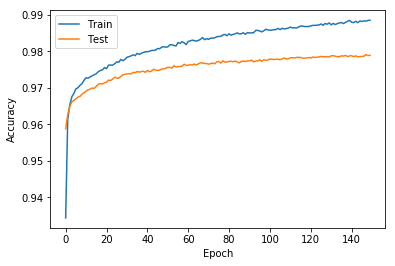

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.9798199999999999
Better model found!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_79 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_80 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0       

48000/48000 [==============================] - 2s 49us/step - loss: 0.2619 - acc: 0.9212 - val_loss: 0.1986 - val_acc: 0.9442
Epoch 41/150
48000/48000 [==============================] - 2s 48us/step - loss: 0.2615 - acc: 0.9216 - val_loss: 0.1981 - val_acc: 0.9435
Epoch 42/150
48000/48000 [==============================] - 2s 46us/step - loss: 0.2581 - acc: 0.9230 - val_loss: 0.1960 - val_acc: 0.9448
Epoch 43/150
48000/48000 [==============================] - 2s 44us/step - loss: 0.2601 - acc: 0.9219 - val_loss: 0.1956 - val_acc: 0.9450
Epoch 44/150
48000/48000 [==============================] - 2s 43us/step - loss: 0.2531 - acc: 0.9248 - val_loss: 0.1932 - val_acc: 0.9456
Epoch 45/150
48000/48000 [==============================] - 2s 43us/step - loss: 0.2558 - acc: 0.9234 - val_loss: 0.1928 - val_acc: 0.9453
Epoch 46/150
48000/48000 [==============================] - 2s 43us/step - loss: 0.2547 - acc: 0.9236 - val_loss: 0.1908 - val_acc: 0.9467
Epoch 47/150
48000/48000 [==============

48000/48000 [==============================] - 2s 46us/step - loss: 0.1831 - acc: 0.9440 - val_loss: 0.1448 - val_acc: 0.9598
Epoch 100/150
48000/48000 [==============================] - 2s 46us/step - loss: 0.1820 - acc: 0.9456 - val_loss: 0.1462 - val_acc: 0.9594
Epoch 101/150
48000/48000 [==============================] - 2s 44us/step - loss: 0.1829 - acc: 0.9451 - val_loss: 0.1436 - val_acc: 0.9608
Epoch 102/150
48000/48000 [==============================] - 2s 44us/step - loss: 0.1828 - acc: 0.9446 - val_loss: 0.1449 - val_acc: 0.9598
Epoch 103/150
48000/48000 [==============================] - 2s 43us/step - loss: 0.1787 - acc: 0.9449 - val_loss: 0.1431 - val_acc: 0.9608
Epoch 104/150
48000/48000 [==============================] - 2s 45us/step - loss: 0.1813 - acc: 0.9444 - val_loss: 0.1424 - val_acc: 0.9608
Epoch 105/150
48000/48000 [==============================] - 2s 45us/step - loss: 0.1793 - acc: 0.9455 - val_loss: 0.1435 - val_acc: 0.9604
Epoch 106/150
48000/48000 [=======

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Round: 5. Time: 0:05:03.050198. Total time: 0:25:44.781710. Expected: 0:25:44.781710
Test score: 0.08306779963225126
Test accuracy: 0.9779


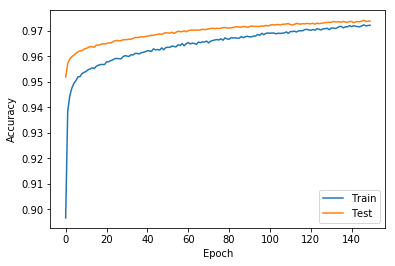

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.9731
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_85 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_86 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_____________________________

48000/48000 [==============================] - 2s 48us/step - loss: 0.2641 - acc: 0.9209 - val_loss: 0.1968 - val_acc: 0.9455
Epoch 100/150
48000/48000 [==============================] - 2s 47us/step - loss: 0.2634 - acc: 0.9216 - val_loss: 0.1956 - val_acc: 0.9459
Epoch 101/150
48000/48000 [==============================] - 3s 53us/step - loss: 0.2609 - acc: 0.9231 - val_loss: 0.1964 - val_acc: 0.9458
Epoch 102/150
48000/48000 [==============================] - 3s 57us/step - loss: 0.2603 - acc: 0.9234 - val_loss: 0.1954 - val_acc: 0.9465
Epoch 103/150
48000/48000 [==============================] - 2s 48us/step - loss: 0.2612 - acc: 0.9228 - val_loss: 0.1953 - val_acc: 0.9461
Epoch 104/150
48000/48000 [==============================] - 3s 54us/step - loss: 0.2584 - acc: 0.9234 - val_loss: 0.1942 - val_acc: 0.9463
Epoch 105/150
48000/48000 [==============================] - 2s 45us/step - loss: 0.2574 - acc: 0.9241 - val_loss: 0.1931 - val_acc: 0.9467
Epoch 106/150
48000/48000 [=======

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Round: 5. Time: 0:04:43.572235. Total time: 0:25:08.655823. Expected: 0:25:08.655823
Test score: 0.1202201111247763
Test accuracy: 0.9711


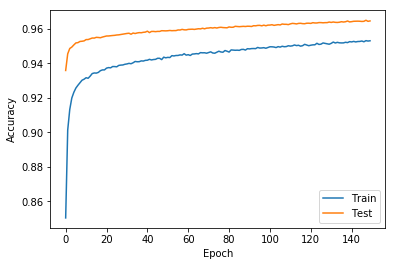

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.9627399999999999
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_91 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_92 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________

48000/48000 [==============================] - 2s 42us/step - loss: 0.3702 - acc: 0.8938 - val_loss: 0.2691 - val_acc: 0.9272
Epoch 100/150
48000/48000 [==============================] - 2s 42us/step - loss: 0.3682 - acc: 0.8959 - val_loss: 0.2696 - val_acc: 0.9268
Epoch 101/150
48000/48000 [==============================] - 2s 42us/step - loss: 0.3679 - acc: 0.8968 - val_loss: 0.2693 - val_acc: 0.9270
Epoch 102/150
48000/48000 [==============================] - 2s 42us/step - loss: 0.3656 - acc: 0.8969 - val_loss: 0.2694 - val_acc: 0.9287
Epoch 103/150
48000/48000 [==============================] - 2s 42us/step - loss: 0.3671 - acc: 0.8947 - val_loss: 0.2690 - val_acc: 0.9273
Epoch 104/150
48000/48000 [==============================] - 2s 42us/step - loss: 0.3653 - acc: 0.8966 - val_loss: 0.2661 - val_acc: 0.9284
Epoch 105/150
48000/48000 [==============================] - 2s 43us/step - loss: 0.3636 - acc: 0.8976 - val_loss: 0.2659 - val_acc: 0.9280
Epoch 106/150
48000/48000 [=======

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Round: 5. Time: 0:04:48.536953. Total time: 0:24:35.780958. Expected: 0:24:35.780958
Test score: 0.16371010406762362
Test accuracy: 0.9611


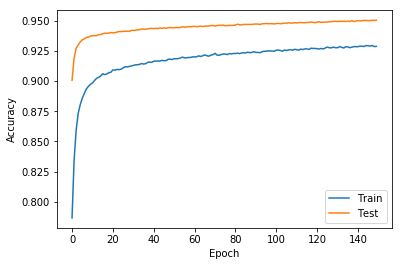

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.9481400000000001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_97 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_98 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________

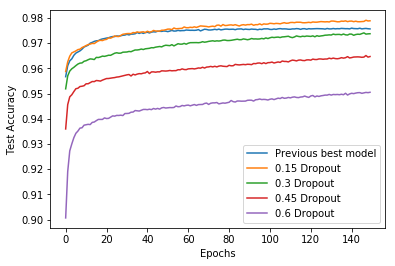

In [14]:
# Change the dropout rate
results = evaluate_hp(model, results, 'dropout', (0.15, 0.3, 0.45, 0.6), 'Dropout', 'drop')

Train on 48000 samples, validate on 12000 samples
Epoch 1/150
48000/48000 [==============================] - 5s 94us/step - loss: 0.4223 - acc: 0.8687 - val_loss: 0.2184 - val_acc: 0.9338
Epoch 2/150
48000/48000 [==============================] - 2s 50us/step - loss: 0.2243 - acc: 0.9317 - val_loss: 0.1570 - val_acc: 0.9531
Epoch 3/150
48000/48000 [==============================] - 3s 66us/step - loss: 0.1703 - acc: 0.9486 - val_loss: 0.1445 - val_acc: 0.9597
Epoch 4/150
48000/48000 [==============================] - 2s 50us/step - loss: 0.1384 - acc: 0.9577 - val_loss: 0.1273 - val_acc: 0.9655
Epoch 5/150
48000/48000 [==============================] - 3s 53us/step - loss: 0.1206 - acc: 0.9637 - val_loss: 0.1125 - val_acc: 0.9682
Epoch 6/150
48000/48000 [==============================] - 3s 58us/step - loss: 0.1024 - acc: 0.9690 - val_loss: 0.1155 - val_acc: 0.9692
Epoch 7/150
48000/48000 [==============================] - 3s 60us/step - loss: 0.0916 - acc: 0.9728 - val_loss: 0.1032 - 

Epoch 118/150
48000/48000 [==============================] - 2s 44us/step - loss: 0.0063 - acc: 0.9986 - val_loss: 0.1585 - val_acc: 0.9793
Epoch 119/150
48000/48000 [==============================] - 2s 44us/step - loss: 0.0080 - acc: 0.9980 - val_loss: 0.1603 - val_acc: 0.9791
Epoch 120/150
48000/48000 [==============================] - 2s 44us/step - loss: 0.0060 - acc: 0.9985 - val_loss: 0.1542 - val_acc: 0.9799
Epoch 121/150
48000/48000 [==============================] - 2s 44us/step - loss: 0.0067 - acc: 0.9981 - val_loss: 0.1655 - val_acc: 0.9788
Epoch 122/150
48000/48000 [==============================] - 2s 45us/step - loss: 0.0063 - acc: 0.9982 - val_loss: 0.1621 - val_acc: 0.9772
Epoch 123/150
48000/48000 [==============================] - 2s 44us/step - loss: 0.0066 - acc: 0.9981 - val_loss: 0.1392 - val_acc: 0.9815
Epoch 124/150
48000/48000 [==============================] - 2s 44us/step - loss: 0.0076 - acc: 0.9980 - val_loss: 0.1548 - val_acc: 0.9791
Epoch 125/150
48000/

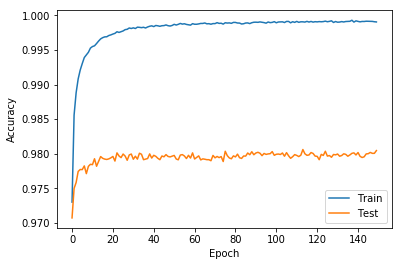

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.9818
Better model found!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________

48000/48000 [==============================] - 2s 49us/step - loss: 0.0141 - acc: 0.9953 - val_loss: 0.1220 - val_acc: 0.9781
Epoch 100/150
48000/48000 [==============================] - 2s 47us/step - loss: 0.0112 - acc: 0.9963 - val_loss: 0.1239 - val_acc: 0.9772
Epoch 101/150
48000/48000 [==============================] - 2s 47us/step - loss: 0.0129 - acc: 0.9960 - val_loss: 0.1328 - val_acc: 0.9772
Epoch 102/150
48000/48000 [==============================] - 2s 48us/step - loss: 0.0152 - acc: 0.9951 - val_loss: 0.1310 - val_acc: 0.9771
Epoch 103/150
48000/48000 [==============================] - 2s 48us/step - loss: 0.0115 - acc: 0.9962 - val_loss: 0.1279 - val_acc: 0.9772
Epoch 104/150
48000/48000 [==============================] - 2s 49us/step - loss: 0.0138 - acc: 0.9958 - val_loss: 0.1266 - val_acc: 0.9776
Epoch 105/150
48000/48000 [==============================] - 2s 48us/step - loss: 0.0115 - acc: 0.9962 - val_loss: 0.1250 - val_acc: 0.9779
Epoch 106/150
48000/48000 [=======

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Round: 5. Time: 0:05:47.608497. Total time: 0:29:00.534790. Expected: 0:29:00.534790
Test score: 0.11641090316942428
Test accuracy: 0.9805


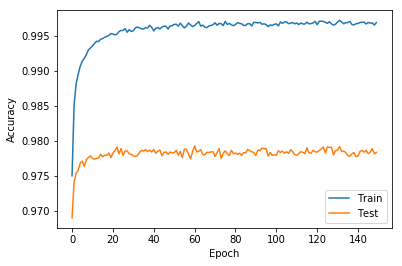

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.97944
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               200960    
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_8 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
____________________________

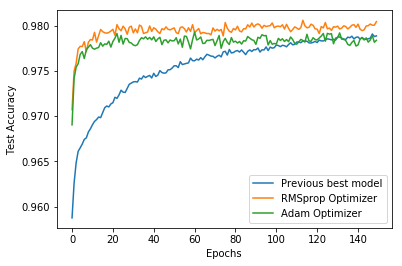

In [10]:
# Change the optimizer
opts = (RMSprop, Adam)
opts_names = [i.__name__ for i in opts]
keys = ['MLP_{}_optimizer'.format(opt) for opt in opts_names]
for opt, key in zip(opts, keys):
    results[key] = model.create_train(optimizer=opt)

model.plot_comparison(results, keys, opts_names, 'Optimizer', 'Opt')
dump_all(model, results)

Train on 48000 samples, validate on 12000 samples
Epoch 1/150
48000/48000 [==============================] - 3s 68us/step - loss: 0.4202 - acc: 0.8692 - val_loss: 0.2219 - val_acc: 0.9337
Epoch 2/150
48000/48000 [==============================] - 3s 54us/step - loss: 0.2220 - acc: 0.9318 - val_loss: 0.1848 - val_acc: 0.9467
Epoch 3/150
48000/48000 [==============================] - 3s 54us/step - loss: 0.1722 - acc: 0.9489 - val_loss: 0.1476 - val_acc: 0.9576
Epoch 4/150
48000/48000 [==============================] - 3s 58us/step - loss: 0.1378 - acc: 0.9586 - val_loss: 0.1289 - val_acc: 0.9612
Epoch 5/150
48000/48000 [==============================] - 3s 58us/step - loss: 0.1195 - acc: 0.9640 - val_loss: 0.1218 - val_acc: 0.9653
Epoch 6/150
48000/48000 [==============================] - 3s 54us/step - loss: 0.1002 - acc: 0.9697 - val_loss: 0.1163 - val_acc: 0.9681
Epoch 7/150
48000/48000 [==============================] - 2s 51us/step - loss: 0.0894 - acc: 0.9731 - val_loss: 0.1148 - 

Epoch 118/150
48000/48000 [==============================] - 2s 47us/step - loss: 0.0063 - acc: 0.9982 - val_loss: 0.1550 - val_acc: 0.9799
Epoch 119/150
48000/48000 [==============================] - 2s 49us/step - loss: 0.0060 - acc: 0.9982 - val_loss: 0.1589 - val_acc: 0.9794
Epoch 120/150
48000/48000 [==============================] - 2s 49us/step - loss: 0.0047 - acc: 0.9983 - val_loss: 0.1536 - val_acc: 0.9797
Epoch 121/150
48000/48000 [==============================] - 3s 63us/step - loss: 0.0049 - acc: 0.9986 - val_loss: 0.1626 - val_acc: 0.9792
Epoch 122/150
48000/48000 [==============================] - 3s 53us/step - loss: 0.0059 - acc: 0.9984 - val_loss: 0.1441 - val_acc: 0.9810
Epoch 123/150
48000/48000 [==============================] - 2s 52us/step - loss: 0.0057 - acc: 0.9984 - val_loss: 0.1548 - val_acc: 0.9797
Epoch 124/150
48000/48000 [==============================] - 2s 47us/step - loss: 0.0054 - acc: 0.9984 - val_loss: 0.1646 - val_acc: 0.9796
Epoch 125/150
48000/

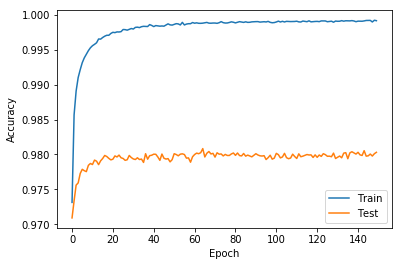

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.9802199999999999
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_14 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________

48000/48000 [==============================] - 2s 46us/step - loss: 0.1426 - acc: 0.9632 - val_loss: 0.1539 - val_acc: 0.9633
Epoch 100/150
48000/48000 [==============================] - 2s 46us/step - loss: 0.1390 - acc: 0.9637 - val_loss: 0.1532 - val_acc: 0.9644
Epoch 101/150
48000/48000 [==============================] - 2s 48us/step - loss: 0.1431 - acc: 0.9625 - val_loss: 0.1413 - val_acc: 0.9655
Epoch 102/150
48000/48000 [==============================] - 2s 47us/step - loss: 0.1414 - acc: 0.9632 - val_loss: 0.1519 - val_acc: 0.9634
Epoch 103/150
48000/48000 [==============================] - 2s 47us/step - loss: 0.1445 - acc: 0.9627 - val_loss: 0.1449 - val_acc: 0.9666
Epoch 104/150
48000/48000 [==============================] - 2s 46us/step - loss: 0.1354 - acc: 0.9646 - val_loss: 0.1534 - val_acc: 0.9640
Epoch 105/150
48000/48000 [==============================] - 2s 46us/step - loss: 0.1338 - acc: 0.9659 - val_loss: 0.1638 - val_acc: 0.9626
Epoch 106/150
48000/48000 [=======

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Round: 5. Time: 0:05:30.284626. Total time: 0:28:16.810926. Expected: 0:28:16.810926
Test score: 0.21710050716996193
Test accuracy: 0.9502


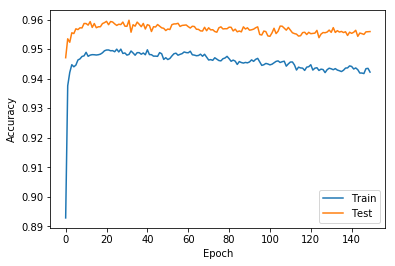

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.9560799999999998
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_19 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_20 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________

48000/48000 [==============================] - 2s 51us/step - loss: 3.0918 - acc: 0.1020 - val_loss: 3.2106 - val_acc: 0.0956
Epoch 100/150
48000/48000 [==============================] - 2s 49us/step - loss: 3.0880 - acc: 0.1016 - val_loss: 3.1605 - val_acc: 0.0975
Epoch 101/150
48000/48000 [==============================] - 2s 48us/step - loss: 3.1293 - acc: 0.0993 - val_loss: 2.9822 - val_acc: 0.0998
Epoch 102/150
48000/48000 [==============================] - 2s 49us/step - loss: 3.0998 - acc: 0.1016 - val_loss: 2.9492 - val_acc: 0.1081
Epoch 103/150
48000/48000 [==============================] - 2s 50us/step - loss: 3.1192 - acc: 0.0961 - val_loss: 3.5469 - val_acc: 0.0998
Epoch 104/150
48000/48000 [==============================] - 2s 49us/step - loss: 3.1055 - acc: 0.0991 - val_loss: 3.0720 - val_acc: 0.0995
Epoch 105/150
48000/48000 [==============================] - 3s 67us/step - loss: 3.1032 - acc: 0.1012 - val_loss: 3.2754 - val_acc: 0.1060
Epoch 106/150
48000/48000 [=======

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Round: 5. Time: 0:05:41.030998. Total time: 0:29:51.155652. Expected: 0:29:51.155652
Test score: 2.77579206161499
Test accuracy: 0.1135


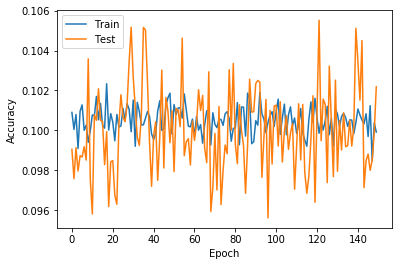

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.10525999999999999
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_25 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_26 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
________________

48000/48000 [==============================] - 2s 48us/step - loss: 12.3008 - acc: 0.0988 - val_loss: 11.9096 - val_acc: 0.0989
Epoch 98/150
48000/48000 [==============================] - 2s 48us/step - loss: 12.2916 - acc: 0.1007 - val_loss: 12.5144 - val_acc: 0.0989
Epoch 99/150
48000/48000 [==============================] - 2s 49us/step - loss: 12.3169 - acc: 0.1005 - val_loss: 11.9415 - val_acc: 0.0956
Epoch 100/150
48000/48000 [==============================] - 2s 48us/step - loss: 12.2961 - acc: 0.1004 - val_loss: 11.9617 - val_acc: 0.1035
Epoch 101/150
48000/48000 [==============================] - 2s 47us/step - loss: 12.2834 - acc: 0.1011 - val_loss: 12.6493 - val_acc: 0.0956
Epoch 102/150
48000/48000 [==============================] - 2s 48us/step - loss: 12.3099 - acc: 0.1005 - val_loss: 12.7827 - val_acc: 0.1035
Epoch 103/150
48000/48000 [==============================] - 2s 52us/step - loss: 12.3114 - acc: 0.0976 - val_loss: 12.6278 - val_acc: 0.1035
Epoch 104/150
48000/48

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Round: 4. Time: 0:05:41.480983. Total time: 0:23:06.815556. Expected: 0:28:53.519445
Test score: 12.29018757019043
Test accuracy: 0.101
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Round: 5. Time: 0:05:47.149182. Total time: 0:28:53.965736. Expected: 0:28:53.965736
Test score: 11.912078396606445
Test accuracy: 0.101


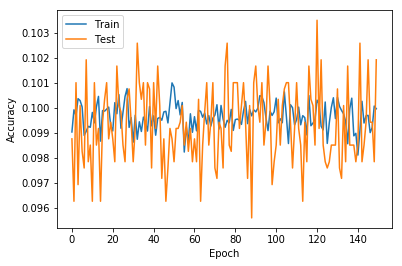

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.10098
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_31 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_32 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
____________________________

Epoch 40/150
48000/48000 [==============================] - 2s 50us/step - loss: 14.2813 - acc: 0.1140 - val_loss: 14.4096 - val_acc: 0.1060
Epoch 41/150
48000/48000 [==============================] - 2s 49us/step - loss: 14.2813 - acc: 0.1140 - val_loss: 14.4096 - val_acc: 0.1060
Epoch 42/150
48000/48000 [==============================] - 2s 48us/step - loss: 14.2813 - acc: 0.1140 - val_loss: 14.4096 - val_acc: 0.1060
Epoch 43/150
48000/48000 [==============================] - 2s 50us/step - loss: 14.2813 - acc: 0.1140 - val_loss: 14.4096 - val_acc: 0.1060
Epoch 44/150
48000/48000 [==============================] - 2s 49us/step - loss: 14.2813 - acc: 0.1140 - val_loss: 14.4096 - val_acc: 0.1060
Epoch 45/150
48000/48000 [==============================] - 2s 49us/step - loss: 14.2813 - acc: 0.1140 - val_loss: 14.4096 - val_acc: 0.1060
Epoch 46/150
48000/48000 [==============================] - 2s 50us/step - loss: 14.2813 - acc: 0.1140 - val_loss: 14.4096 - val_acc: 0.1060
Epoch 47/150


*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Round: 4. Time: 0:05:16.541380. Total time: 0:22:23.394387. Expected: 0:27:59.242984
Test score: 14.288691453552246
Test accuracy: 0.1135
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Round: 5. Time: 0:05:21.463218. Total time: 0:27:44.858603. Expected: 0:27:44.858603
Test score: 14.288691453552246
Test accuracy: 0.1135


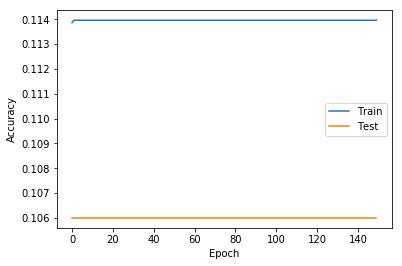

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.1135
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_37 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_38 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)               0         
_____________________________

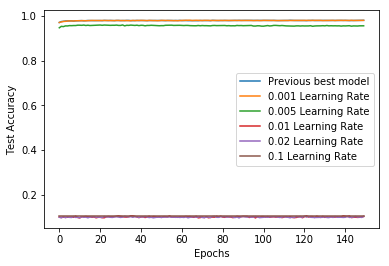

In [11]:
# Change the learning rate
lrs = (0.0001, 0.001, 0.01)
keys = ['MLP_{}_LR'.format(lr) for lr in lrs]
for lr, key in zip(lrs, keys):
    results[key] = model.create_train(optimizer_params={'lr':lr})
    
model.plot_comparison(results, keys, lrs, 'Learning Rate', 'LR')
dump_all(model, results)

Train on 48000 samples, validate on 12000 samples
Epoch 1/150
48000/48000 [==============================] - 5s 107us/step - loss: 0.5993 - acc: 0.8275 - val_loss: 0.2925 - val_acc: 0.9132
Epoch 2/150
48000/48000 [==============================] - 3s 53us/step - loss: 0.3379 - acc: 0.8998 - val_loss: 0.2535 - val_acc: 0.9243
Epoch 3/150
48000/48000 [==============================] - 3s 54us/step - loss: 0.2962 - acc: 0.9125 - val_loss: 0.2265 - val_acc: 0.9325
Epoch 4/150
48000/48000 [==============================] - 3s 54us/step - loss: 0.2690 - acc: 0.9189 - val_loss: 0.2111 - val_acc: 0.9387
Epoch 5/150
48000/48000 [==============================] - 3s 57us/step - loss: 0.2428 - acc: 0.9277 - val_loss: 0.1969 - val_acc: 0.9413
Epoch 6/150
48000/48000 [==============================] - 3s 59us/step - loss: 0.2224 - acc: 0.9327 - val_loss: 0.1760 - val_acc: 0.9490
Epoch 7/150
48000/48000 [==============================] - 3s 58us/step - loss: 0.2060 - acc: 0.9391 - val_loss: 0.1631 -

Epoch 118/150
48000/48000 [==============================] - 3s 60us/step - loss: 0.0144 - acc: 0.9952 - val_loss: 0.0985 - val_acc: 0.9802
Epoch 119/150
48000/48000 [==============================] - 3s 53us/step - loss: 0.0145 - acc: 0.9951 - val_loss: 0.1084 - val_acc: 0.9787
Epoch 120/150
48000/48000 [==============================] - 2s 49us/step - loss: 0.0140 - acc: 0.9952 - val_loss: 0.0997 - val_acc: 0.9805
Epoch 121/150
48000/48000 [==============================] - 2s 49us/step - loss: 0.0139 - acc: 0.9951 - val_loss: 0.1019 - val_acc: 0.9799
Epoch 122/150
48000/48000 [==============================] - 2s 49us/step - loss: 0.0135 - acc: 0.9951 - val_loss: 0.1003 - val_acc: 0.9800
Epoch 123/150
48000/48000 [==============================] - 2s 48us/step - loss: 0.0136 - acc: 0.9954 - val_loss: 0.0966 - val_acc: 0.9802
Epoch 124/150
48000/48000 [==============================] - 2s 49us/step - loss: 0.0132 - acc: 0.9954 - val_loss: 0.1005 - val_acc: 0.9794
Epoch 125/150
48000/

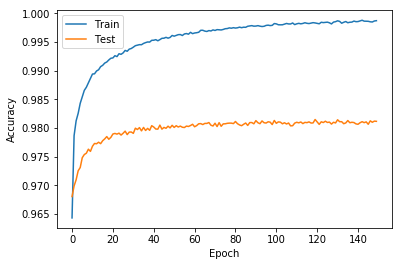

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.98234
Better model found!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_55 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_56 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 256)               0         
________

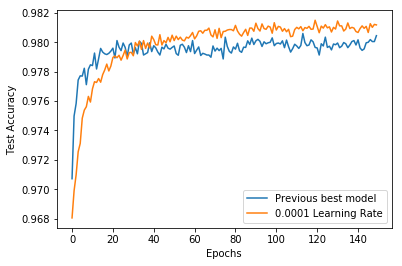

In [17]:
lrs = (0.0001,)
keys = ['MLP_{}_LR'.format(lr) for lr in lrs]
for lr, key in zip(lrs, keys):
    results[key] = model.create_train(optimizer_params={'lr':lr})
    
model.plot_comparison(results, keys, lrs, 'Learning Rate', 'LR')
dump_all(model, results)

Train on 48000 samples, validate on 12000 samples
Epoch 1/150
48000/48000 [==============================] - 4s 78us/step - loss: 0.4203 - acc: 0.8677 - val_loss: 0.2079 - val_acc: 0.9399
Epoch 2/150
48000/48000 [==============================] - 2s 51us/step - loss: 0.2209 - acc: 0.9333 - val_loss: 0.1605 - val_acc: 0.9535
Epoch 3/150
48000/48000 [==============================] - 3s 54us/step - loss: 0.1675 - acc: 0.9491 - val_loss: 0.1463 - val_acc: 0.9579
Epoch 4/150
48000/48000 [==============================] - 3s 57us/step - loss: 0.1355 - acc: 0.9595 - val_loss: 0.1318 - val_acc: 0.9635
Epoch 5/150
48000/48000 [==============================] - 3s 55us/step - loss: 0.1175 - acc: 0.9646 - val_loss: 0.1082 - val_acc: 0.9682
Epoch 6/150
48000/48000 [==============================] - 2s 52us/step - loss: 0.1023 - acc: 0.9684 - val_loss: 0.1104 - val_acc: 0.9712
Epoch 7/150
48000/48000 [==============================] - 2s 51us/step - loss: 0.0893 - acc: 0.9735 - val_loss: 0.1153 - 

Epoch 118/150
48000/48000 [==============================] - 2s 46us/step - loss: 0.0052 - acc: 0.9985 - val_loss: 0.1618 - val_acc: 0.9797
Epoch 119/150
48000/48000 [==============================] - 2s 47us/step - loss: 0.0058 - acc: 0.9985 - val_loss: 0.1748 - val_acc: 0.9784
Epoch 120/150
48000/48000 [==============================] - 2s 47us/step - loss: 0.0069 - acc: 0.9983 - val_loss: 0.1680 - val_acc: 0.9788
Epoch 121/150
48000/48000 [==============================] - 2s 48us/step - loss: 0.0071 - acc: 0.9981 - val_loss: 0.1627 - val_acc: 0.9792
Epoch 122/150
48000/48000 [==============================] - 2s 46us/step - loss: 0.0066 - acc: 0.9983 - val_loss: 0.1633 - val_acc: 0.9797
Epoch 123/150
48000/48000 [==============================] - 2s 46us/step - loss: 0.0060 - acc: 0.9982 - val_loss: 0.1556 - val_acc: 0.9791
Epoch 124/150
48000/48000 [==============================] - 2s 47us/step - loss: 0.0062 - acc: 0.9982 - val_loss: 0.1494 - val_acc: 0.9801
Epoch 125/150
48000/

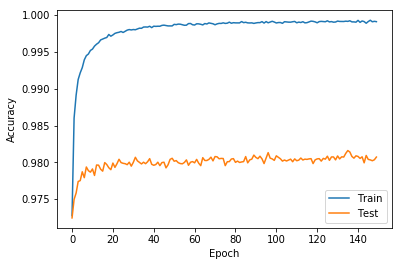

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.9811
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_61 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_62 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 256)               0         
_____________________________

48000/48000 [==============================] - 2s 48us/step - loss: 0.0074 - acc: 0.9978 - val_loss: 0.1411 - val_acc: 0.9793
Epoch 100/150
48000/48000 [==============================] - 2s 47us/step - loss: 0.0065 - acc: 0.9982 - val_loss: 0.1391 - val_acc: 0.9802
Epoch 101/150
48000/48000 [==============================] - 2s 49us/step - loss: 0.0055 - acc: 0.9983 - val_loss: 0.1586 - val_acc: 0.9784
Epoch 102/150
48000/48000 [==============================] - 2s 48us/step - loss: 0.0064 - acc: 0.9981 - val_loss: 0.1532 - val_acc: 0.9789
Epoch 103/150
48000/48000 [==============================] - 2s 48us/step - loss: 0.0057 - acc: 0.9984 - val_loss: 0.1695 - val_acc: 0.9772
Epoch 104/150
48000/48000 [==============================] - 2s 48us/step - loss: 0.0060 - acc: 0.9983 - val_loss: 0.1559 - val_acc: 0.9788
Epoch 105/150
48000/48000 [==============================] - 2s 49us/step - loss: 0.0059 - acc: 0.9984 - val_loss: 0.1552 - val_acc: 0.9802
Epoch 106/150
48000/48000 [=======

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Round: 5. Time: 0:05:30.733454. Total time: 0:27:53.221699. Expected: 0:27:53.221699
Test score: 0.19646098682292257
Test accuracy: 0.9819


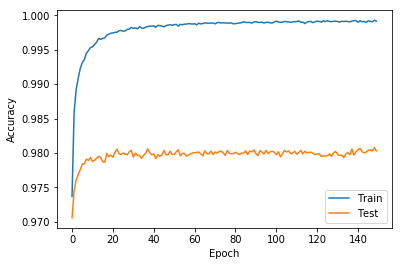

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Mean test acc: 0.98102
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_67 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_68 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 256)               0         
____________________________

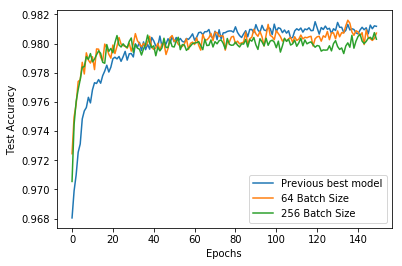

In [18]:
# Change batch size
results = evaluate_hp(model, results, 'batch_size', (64,256), 'Batch Size', 'BS')

In [19]:
model.best_model_summary()

Hidden Layers: 5
Hidden Units: 256
Epochs: 150
Activation: tanh
Dropout: 0.15
Optimizer: type
Batch size: 128
Accuracy: 0.98234
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_67 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_68 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 256)               0         
______________